这个笔记本尝试了通过神经网络 DeepONets 来求解位势方程。 
更新：使用训练好的数据和模型，然后处理数据。

批量加载训练好的数据，可以使用不同的参数。

This set of parameters are good:
crit = 1
data = 30
strc = 2
stretch_para = 50
batch_size = 50
loss_weight = 1.0

Or, this set of parameters:
crit = 1
data = 30
strc = 1
stretch_para = 50
batch_size = 25
loss_weight = 10.0

This set of parameter uses $\ell^2$ relative error as the loss function:
crit = 2
data = 30
strc = 2
stretch_para = 50
batch_size = 1
loss_weight = 0.1

In [1]:
crit = 1
data = 30
strc = 2
stretch_para = 50
batch_size = 50
loss_weight = 1.0


# 设置数据集相关参数
if data == 30:
    data_id = 29
    n_points = 30  # 每个函数的采样点数量
    total_sample = 1000
    epochs = 5000
elif data == 81:
    data_id = 26
    n_points = 81  # 每个函数的采样点数量
    total_sample = 500
    epochs = 1200

# 设置网络结构
if strc == 1:
    hidden_dims = [100, 100, 100]
    output_dim = 50
elif strc == 2:
    hidden_dims = [200, 200, 200, 200]
    output_dim = 100

In [2]:
import os
import numpy as np

home_dir = os.path.expanduser("~")  # 获取 home 目录
source_path = os.path.join(home_dir, f"DLL/data/202409{data_id}_source_data.npz")  # 得到 source 数据集的路径
print(source_path)  # 打印 source文件的完整路径
source_data = np.load(source_path)
sources = stretch_para*source_data['sources']
print("Source data loaded from the file.")


solution_path = os.path.join(home_dir, f"DLL/data/202409{data_id}_solution_data.npz")  # 得到 solution 数据集的路径
print(solution_path)  # 打印 solution文件的完整路径
solution_data = np.load(solution_path)
solutions = stretch_para*solution_data['solutions']
print("Solution data loaded from the file.")

/people/weiz828/DLL/data/20240929_source_data.npz
Source data loaded from the file.
/people/weiz828/DLL/data/20240929_solution_data.npz
Solution data loaded from the file.


Plotting random 2D function and its Poisson solution for sample index: 147


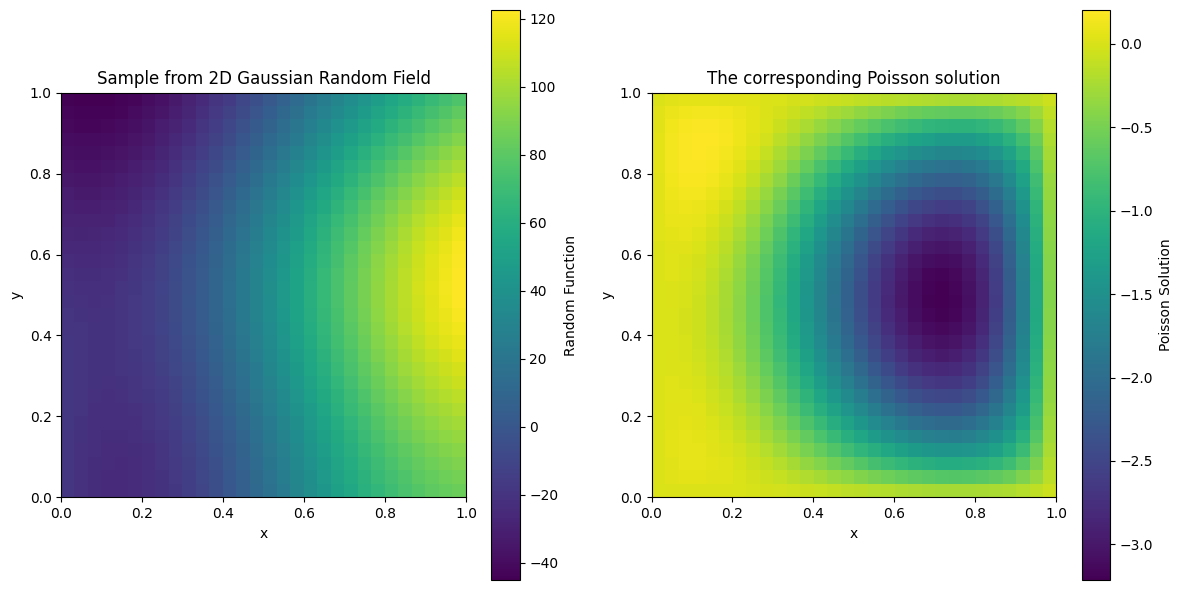

In [3]:
# Plot a random 2D function and its Poisson solution from the loaded files
import matplotlib.pyplot as plt
import random
rand_idx = random.randint(0, 500)  # 生成1到100之间的随机整数

print(f"Plotting random 2D function and its Poisson solution for sample index: {rand_idx}")

# 创建一个包含两张图片的图形
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# 第一个图片：2D Gaussian Random Field
im1 = axs[0].imshow(sources[rand_idx], extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
axs[0].set_title('Sample from 2D Gaussian Random Field')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
fig.colorbar(im1, ax=axs[0], label='Random Function')

# 第二个图片：Poisson Solution
im2 = axs[1].imshow(solutions[rand_idx], extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
axs[1].set_title('The corresponding Poisson solution')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.colorbar(im2, ax=axs[1], label='Poisson Solution')

# 显示图形
plt.tight_layout()
plt.show()

In [4]:
# 设置训练集和测试集的边界
boundary = int(total_sample*9/10)

In [5]:
# The loaded files contains 2-D functions. In this cell, we store them in 1-D array.

sources_linear = np.zeros((total_sample, n_points*n_points))
solutions_linear = np.zeros((total_sample, n_points*n_points))

for i in range(total_sample):
    sources_linear[i] = sources[i].flatten()
    solutions_linear[i] = solutions[i].flatten()

print(f"The loaded dataset has dimension {sources.shape}, while the arranged linearized dataset has dimension {sources_linear.shape}.")
# print("!!! Note that we only use part of dataset.")


The loaded dataset has dimension (1000, 30, 30), while the arranged linearized dataset has dimension (1000, 900).


In [6]:
# 现在开始处理 y
# y 是新函数的取值点

import numpy as np
import torch

# Define the 2D input grid over [0, 1] x [0, 1]

y1 = np.linspace(0, 1, n_points)
y2 = np.linspace(0, 1, n_points)
Y1, Y2 = np.meshgrid(y1, y2)  # Create a 2D grid
y = np.column_stack([Y1.ravel(), Y2.ravel()])  # Flatten to (n_points^2, 2) shape

y_tensor = torch.tensor(y, dtype=torch.float) # Shape (n_points^2, 2)

In [7]:
# Add a new dimension at the beginning, making the shape [total_sample, n_points^2, 2]
y_expanded = y_tensor.unsqueeze(0)  # Shape: [1, n_points^2, 2]
# print(y_expanded.shape)

y_expanded = y_expanded.expand(total_sample, -1, -1)  # Shape: [total_sample, n_points, 2]

print(y_expanded.shape)

torch.Size([1000, 900, 2])


In [8]:
"""
Design a DeepONet.
"""
import torch
import torch.nn as nn
import torch.optim as optim

# Branch Network
class BranchNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(BranchNet, self).__init__()
        layers = []
        in_dim = input_dim
        
        # 添加多个隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ELU())
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        self.fc = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.fc(x)

# Trunk Network
class TrunkNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(TrunkNet, self).__init__()
        layers = []
        in_dim = input_dim
        
        # 添加多个隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ELU())
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        self.fc = nn.Sequential(*layers)
        
    def forward(self, y):
        return self.fc(y)

# DeepONet
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNet(branch_input_dim, hidden_dims, output_dim)
        self.trunk_net = TrunkNet(trunk_input_dim, hidden_dims, output_dim)
        
    def forward(self, x, y):
        branch_output = self.branch_net(x)
        trunk_output = self.trunk_net(y)
        # Combine the outputs (typically element-wise product)
        output = torch.sum(branch_output * trunk_output, dim=-1, keepdim=True) # 按照最后一个坐标做内积
        return output

In [9]:
u_tensor = torch.tensor(sources_linear[:total_sample], dtype=torch.float) # u_tensor: tensor[total_sample,n_points^2] 
u_expanded = u_tensor.unsqueeze(1) # u_expanded: tensor[total_sample, 1, n_points^2]
u_expanded = u_expanded.expand(-1, y_tensor.size(0), -1) # u_expanded: tensor[total_sample, n_points^2, n_points^2]


s_tensor = torch.tensor(solutions_linear[:total_sample], dtype=torch.float) # s_tensor: tensor[total_sample,n_points^2]
s_expanded = s_tensor.unsqueeze(2)  # s_expanded: tensor[total_sample, n_points^2, 1]

In [10]:
"""
This is the function to well organize the dataset
"""
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input1_data, input2_data, targets):
        self.input1_data = input1_data
        self.input2_data = input2_data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        input1 = self.input1_data[idx]
        input2 = self.input2_data[idx]
        target = self.targets[idx]
        return input1, input2, target

In [11]:
from torch.utils.data import DataLoader
train_set = CustomDataset(u_expanded[:boundary], y_expanded[:boundary], s_expanded[:boundary])
test_set = CustomDataset(u_expanded[boundary:], y_expanded[boundary:], s_expanded[boundary:])

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2) 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2) 

In [12]:
import torch

def edge_mean_square(tensor):
    """
    计算张量边界值的平方平均数。

    参数:
    tensor (torch.Tensor): 一个形状为 [*, H, W] 的张量，其中 H 和 W 是高度和宽度。

    返回:
    float: 边界值平方的平均数。
    """
    # 确保张量的维度是 [*, H, W]
    assert tensor.dim() == 3, "输入张量应为 3D 张量 [*, H, W]"

    # 获取四条边的元素
    top = tensor[:, 0, :]  # 顶边
    bottom = tensor[:, -1, :]  # 底边
    left = tensor[:, :, 0]  # 左边
    right = tensor[:, :, -1]  # 右边

    # 拼接所有边的元素
    edges = torch.cat([top, bottom, left, right], dim=1)

    # 计算边界值的平方
    edges_squared = edges ** 2

    # print(edges_squared.shape)

    # 计算平方值的平均数
    mean_square = edges_squared.mean()

    return mean_square.item()  # 返回浮点数值


# 创建一个形状为 [8, 7, 7] 的张量
tensor = torch.randn(8, n_points, n_points)

# 调用函数计算边界值的平方平均数
result = edge_mean_square(tensor)

print("边界值的平方平均数:", result)

边界值的平方平均数: 0.9522885084152222


In [13]:
def mmse_absolute(prediction, target):
    mse = torch.mean((prediction - target) ** 2)
    prediction = prediction.reshape(-1, n_points, n_points)
    err_bd = edge_mean_square(prediction)
    return mse + loss_weight * err_bd

def mmse_relative(prediction, target, epsilon=1e-6):
    # 计算均方误差
    mse = torch.sum((prediction - target) ** 2) 
    # 计算边界误差
    prediction = prediction.reshape(-1, n_points, n_points)
    err_bd = edge_mean_square(prediction)
    # 在相对误差的分母中加入 epsilon 以处理小值问题
    loss = mse / (torch.sum(target ** 2)) + loss_weight * err_bd
    return loss


if crit == 1:
    mmse=mmse_absolute
elif crit == 2:
    mmse=mmse_relative

In [14]:
# Hyperparameters
branch_input_dim = n_points*n_points  # Number of points to represent the original function
trunk_input_dim = 2     # Coordinate where we evaluate the transformed function
#hidden_dims = [200,200,200,200]
#output_dim = 50

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepONet(branch_input_dim, trunk_input_dim, hidden_dims, output_dim).to(device)

In [15]:
# 加载模型参数
model_para_file = os.path.join(home_dir, f"DLL/2d-train/mod0_crit{crit}_data{data}_strc{strc}_stretch{stretch_para}_batch{batch_size}_loss_weight{loss_weight}.pth")
#model.load_state_dict(torch.load(model_para_file),map_location=torch.device('cpu'))
model.load_state_dict(torch.load(model_para_file, map_location=torch.device(device)))


# 切换为评估模式
model.eval()

/tmp/ipykernel_88447/2102899629.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_para_file, map_location=torch.device(device)))


DeepONet(
  (branch_net): BranchNet(
    (fc): Sequential(
      (0): Linear(in_features=900, out_features=200, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=200, out_features=200, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=200, out_features=100, bias=True)
    )
  )
  (trunk_net): TrunkNet(
    (fc): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=200, out_features=200, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=200, out_features=100, bias=True)
    )
  )
)

In [16]:
import numpy as np

# 加载 .npy 文件
# 加载模型参数
error_array_file = os.path.join(home_dir, f"DLL/2d-train/mod0_crit{crit}_data{data}_strc{strc}_stretch{stretch_para}_batch{batch_size}_loss_weight{loss_weight}.npy")
error_array_loaded = np.load(error_array_file)

mean_values = np.mean(error_array_loaded, axis=1)

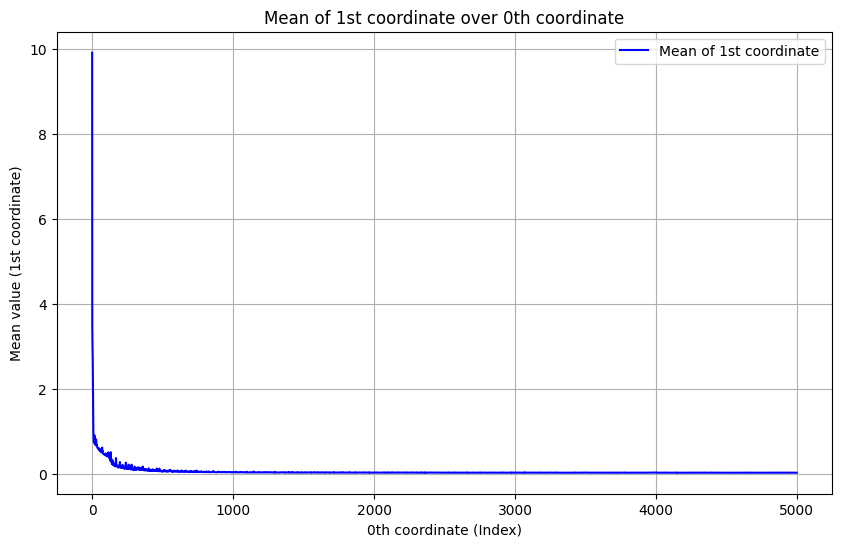

In [17]:
custom_begin = 500
plt.figure(figsize=(10, 6))
plt.plot(range(custom_begin, len(mean_values)), mean_values[custom_begin:], label='Training error', color='b')
plt.title('Mean training error in each epoch')
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.legend()
plt.grid(True)
plt.show()

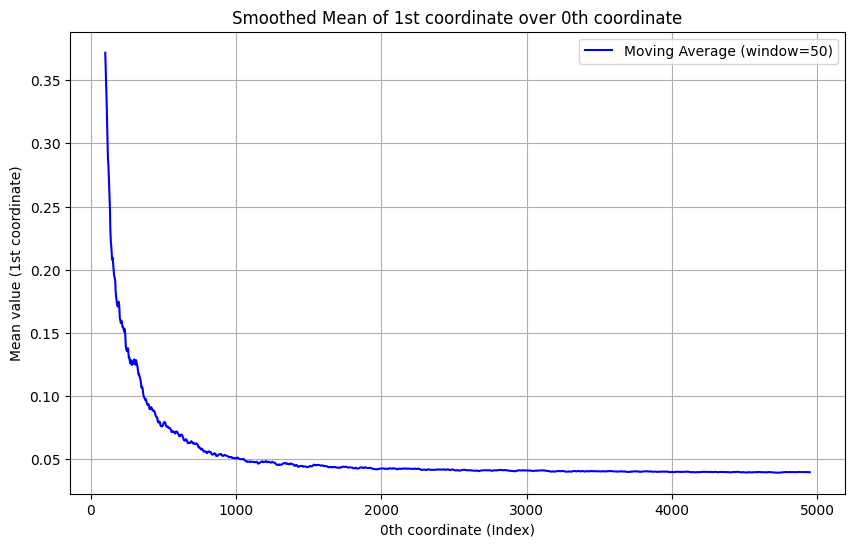

In [18]:
# 定义滑动窗口函数
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 设置滑动窗口大小（例如 50）
window_size = 50
smooth_mean_values = moving_average(mean_values, window_size)

# 创建 x 坐标，滑动平均之后长度会减少 (total_epochs - window_size + 1)
x_values = np.arange(len(smooth_mean_values))

# 绘制图形
plt.figure(figsize=(10, 6))
plt.plot(x_values, smooth_mean_values, label=f'Window-averaged mean training error (window={window_size})', color='b')
plt.title('Window-averaged mean training error in each epoch')
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
with torch.no_grad():
    total_loss = 0
    for input1_batch, input2_batch, target_batch in train_loader:
        input1_batch = input1_batch.to(device)
        input2_batch = input2_batch.to(device)
        target_batch = target_batch.to(device)
        outputs = model(input1_batch, input2_batch)
        loss = mmse(outputs, target_batch)
        total_loss += loss.item()  
        del input1_batch, input2_batch, target_batch, outputs
        torch.cuda.empty_cache()  # 释放当前批次的缓存
    print(f"Train loss: {total_loss/len(train_loader)}")
    
with torch.no_grad():
    total_loss = 0
    for input1_batch, input2_batch, target_batch in test_loader:
        input1_batch = input1_batch.to(device)
        input2_batch = input2_batch.to(device)
        target_batch = target_batch.to(device)
        outputs = model(input1_batch, input2_batch)
        loss = mmse(outputs, target_batch)
        total_loss += loss.item()  
        del input1_batch, input2_batch, target_batch, outputs
        torch.cuda.empty_cache()  # 释放当前批次的缓存
    print(f"Test loss: {total_loss/len(test_loader)}")

Train loss: 0.03902871503184239
Test loss: 0.039899950847029686


In [20]:
import torch
from tqdm.notebook import tqdm

# 定义对最后一维计算 L2 范数的函数
def l2_norm_last_coord_torch(tensor):
    return torch.norm(tensor, p=2, dim=-1)

all_predictions = torch.zeros((total_sample,n_points*n_points))
batch_size_t=10
with torch.no_grad():
    prediction_list = []
    # 分批处理数据
    for i in tqdm(range(0, total_sample, batch_size)):
        u_batch = u_expanded[i:i + batch_size].to(device)
        y_batch = y_tensor.to(device)
        s_batch = s_tensor[i:i + batch_size].to(device)
        # Add a new dimension at the beginning, making the shape [total_sample, n_points^2, 2]
        y_batch = y_batch.unsqueeze(0)  # Shape: [1, n_points^2, 2]
        y_batch = y_batch.expand(batch_size, -1, -1)  # Shape: [total_sample, n_points, 2]
        
        prediction = model(u_batch, y_batch).squeeze()
        all_predictions[i:i+batch_size] = prediction.cpu()  # 将预测结果存储并移动到 CPU
    
        del u_batch, y_batch, s_batch
        torch.cuda.empty_cache()  # 释放当前批次的缓存

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
# 定义对最后一维计算 L2 范数的函数
def l2_norm_last_coord_torch(tensor):
    return torch.norm(tensor, p=2, dim=-1)

absolute_err = torch.zeros((total_sample,n_points*n_points))
absolute_l2_err = np.zeros(total_sample)
relative_l2_err = np.zeros(total_sample)
for i in tqdm(range(total_sample)):
    absolute_err[i] = abs(all_predictions[i] - s_tensor[i])
    absolute_l2_err[i] = l2_norm_last_coord_torch(absolute_err[i])
    relative_l2_err[i] = absolute_l2_err[i] / l2_norm_last_coord_torch(s_tensor[i])
    
train_relative_l2_err = relative_l2_err[:boundary]
test_relative_l2_err = relative_l2_err[boundary:]
train_relative_l2_err = torch.from_numpy(train_relative_l2_err)
test_relative_l2_err = torch.from_numpy(test_relative_l2_err)

  0%|          | 0/1000 [00:00<?, ?it/s]

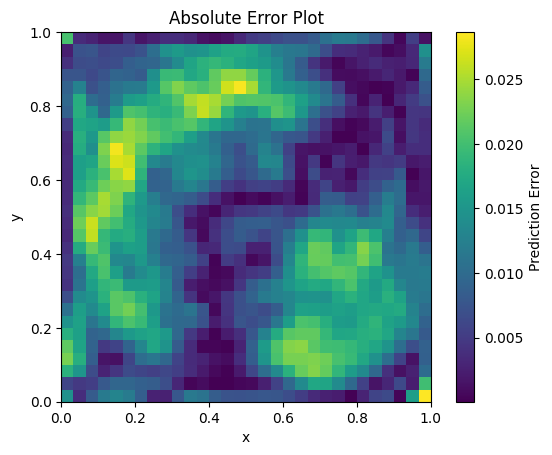

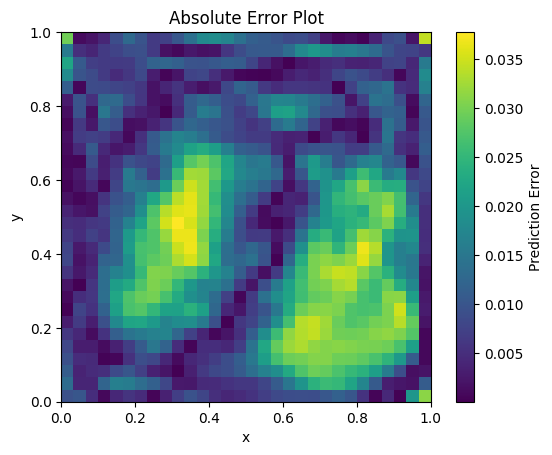

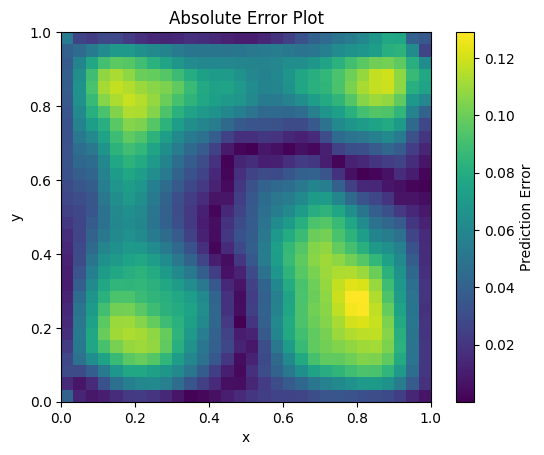

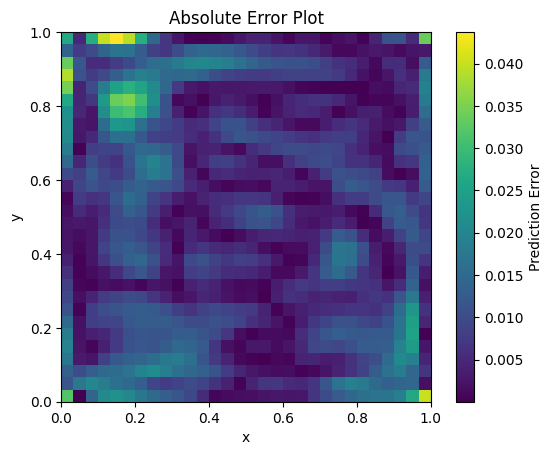

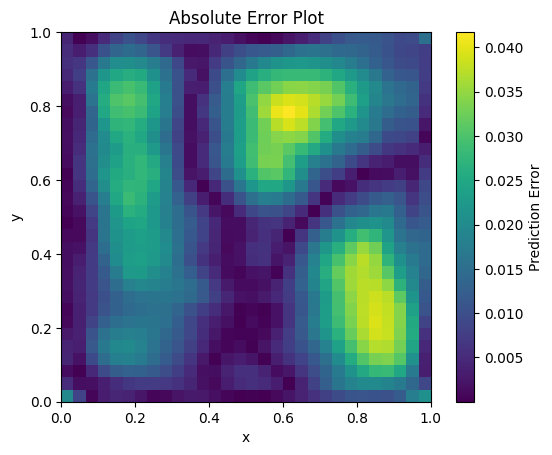

In [22]:
import matplotlib.pyplot as plt

for i in range(boundary,boundary+5): 
    plt.imshow(absolute_err[i].reshape(n_points,n_points), extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
    plt.colorbar(label='Prediction Error')
    plt.title('Absolute Error Plot')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [23]:
import torch

# 计算张量的统计量
def get_statistics_torch(tensor):
    stats = {
        'mean': torch.mean(tensor).item(),
        'std': torch.std(tensor).item(),
        'min': torch.min(tensor).item(),
        'median': torch.median(tensor).item(),
        'max': torch.max(tensor).item()
    }
    return stats

# 比较两个张量的统计量
def compare_statistics(statistics1, statistics2):
    comparison = {}
    for key in statistics1.keys():
        comparison[key] = {
            'train': statistics1[key],
            'test': statistics2[key],
            'difference': statistics1[key] - statistics2[key]  # 计算差异
        }
    return comparison

# 获取训练和测试张量的统计量
train_statistics = get_statistics_torch(train_relative_l2_err)
test_statistics = get_statistics_torch(test_relative_l2_err)

# 打印训练和测试统计量
print("Train Relative Statistics:")
for key, value in train_statistics.items():
    print(f'{key}: {value}')

print("\nTest Relative Statistics:")
for key, value in test_statistics.items():
    print(f'{key}: {value}')

# 比较两个统计量并打印结果
comparison = compare_statistics(train_statistics, test_statistics)

print("\nComparison of Train and Test Statistics:")
for key, values in comparison.items():
    print(f"{key}: Train = {values['train']}, Test = {values['test']}, Absolute Difference = {abs(values['difference'])}")

Train Relative Statistics:
mean: 0.008776309902831498
std: 0.004758574666188871
min: 0.0022993863094598055
median: 0.007334453519433737
max: 0.034585993736982346

Test Relative Statistics:
mean: 0.027506727937143295
std: 0.03946217342510323
min: 0.0037549149710685015
median: 0.011282180435955524
max: 0.24923548102378845

Comparison of Train and Test Statistics:
mean: Train = 0.008776309902831498, Test = 0.027506727937143295, Absolute Difference = 0.018730418034311795
std: Train = 0.004758574666188871, Test = 0.03946217342510323, Absolute Difference = 0.03470359875891436
min: Train = 0.0022993863094598055, Test = 0.0037549149710685015, Absolute Difference = 0.001455528661608696
median: Train = 0.007334453519433737, Test = 0.011282180435955524, Absolute Difference = 0.003947726916521788
max: Train = 0.034585993736982346, Test = 0.24923548102378845, Absolute Difference = 0.2146494872868061


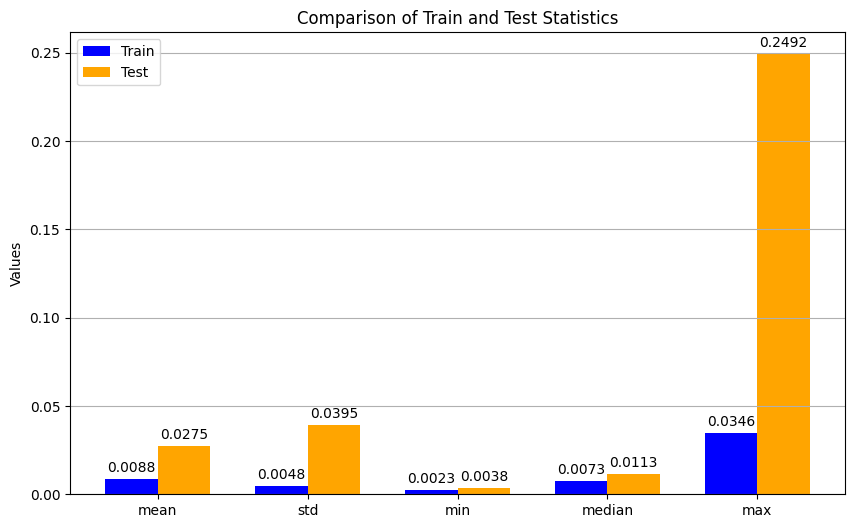

In [24]:
import matplotlib.pyplot as plt

# 提取统计数据用于绘图
labels = list(train_statistics.keys())
train_values = [train_statistics[key] for key in labels]
test_values = [test_statistics[key] for key in labels]

# 设置绘图
bar_positions = np.arange(len(labels))  # 标签的数量
width = 0.35  # 柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(bar_positions - width/2, train_values, width, label='Train', color='b')
bars2 = ax.bar(bar_positions + width/2, test_values, width, label='Test', color='orange')

# 添加一些标签和标题
ax.set_ylabel('Values')
ax.set_title('Comparison of Train and Test Statistics')
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
ax.legend()

# 添加数据标签，保留更多小数点
def add_data_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',  # 修改为保留四位小数
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 向上偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

add_data_labels(bars1)
add_data_labels(bars2)

plt.grid(axis='y')
plt.show()

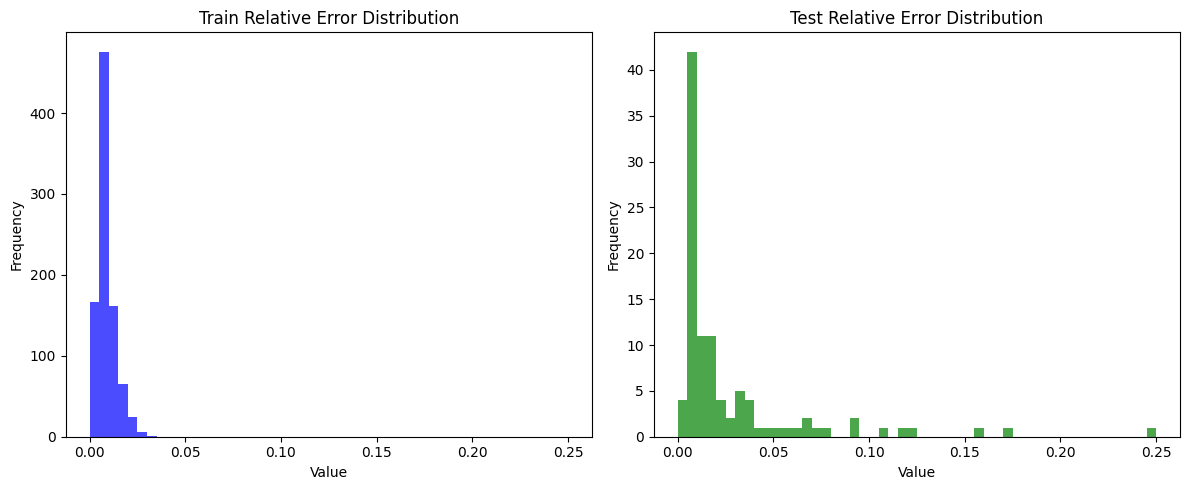

In [25]:
import torch
import matplotlib.pyplot as plt

def plot_dual_histogram(tensor1, tensor2, bins=50, range=(0, 0.25), color1='blue', color2='green', 
                        title1='Train Relative Error Distribution', title2='Test Relative Error Distribution'):
    """
    并排绘制两个 1 维张量的直方图。

    参数:
    tensor1: 第一个 1 维张量 (torch.Tensor)
    tensor2: 第二个 1 维张量 (torch.Tensor)
    bins: 直方图的分区数量 (默认值为 30)
    color1: 第一个直方图的颜色 (默认值为 'blue')
    color2: 第二个直方图的颜色 (默认值为 'green')
    title1: 第一个图表的标题 (默认值为 'Tensor 1 Distribution')
    title2: 第二个图表的标题 (默认值为 'Tensor 2 Distribution')
    """
    # 创建两个子图，分别用于绘制两个张量的直方图
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 绘制第一个张量的直方图
    axs[0].hist(tensor1.numpy(), bins=bins, range = range, alpha=0.7, color=color1)
    axs[0].set_title(title1)
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # 绘制第二个张量的直方图
    axs[1].hist(tensor2.numpy(), bins=bins, range = range, alpha=0.7, color=color2)
    axs[1].set_title(title2)
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')

    # 显示并排的图像
    plt.tight_layout()
    
    output_image = os.path.join(home_dir, f"DLL/2d-train/mod0_crit{crit}_data{data}_strc{strc}_stretch{stretch_para}_batch{batch_size}_loss_weight{loss_weight}.png")
    # 文件名格式

    # 保存图像为 PNG 文件
    plt.savefig(output_image)

    plt.show()
# 使用示例
plot_dual_histogram(train_relative_l2_err, test_relative_l2_err)

The relative error for sample 44 in test set is 0.24923548102378845


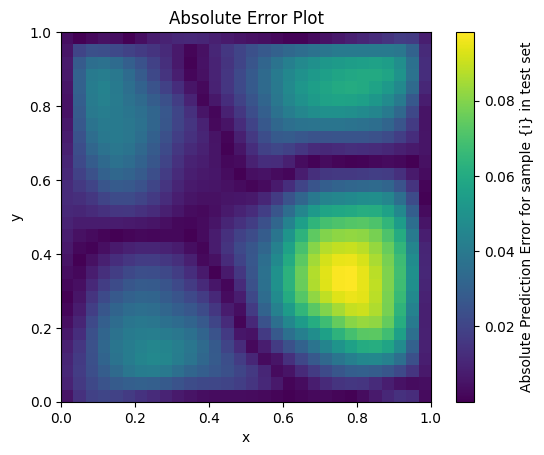

The relative error for sample 93 in test set is 0.1732759028673172


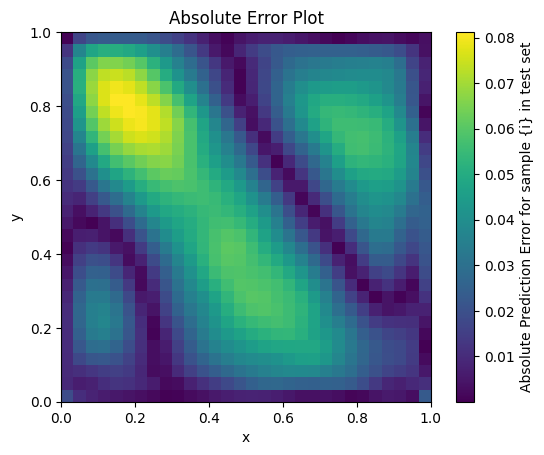

The relative error for sample 75 in test set is 0.15508407354354858


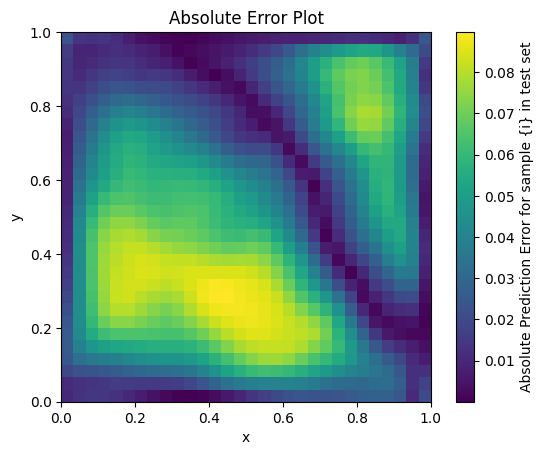

The relative error for sample 9 in test set is 0.12001016736030579


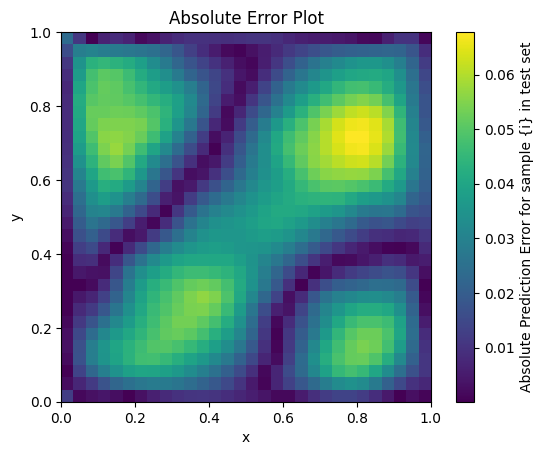

The relative error for sample 16 in test set is 0.11831769347190857


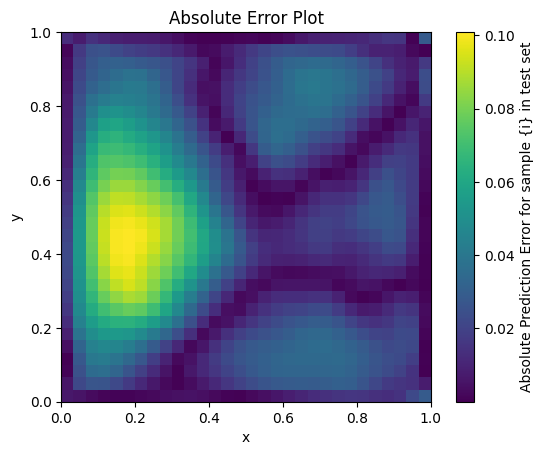

In [26]:
import matplotlib.pyplot as plt

top_k = torch.topk(test_relative_l2_err, k=5)

for j in top_k.indices:
    i = j.item()    
    print(f'The relative error for sample {i} in test set is {test_relative_l2_err[j].item()}')
    temp = all_predictions[boundary+i].reshape(n_points,n_points)
    plt.imshow(abs(temp-solutions[boundary+i]), extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
    plt.colorbar(label='Absolute Prediction Error for sample {i} in test set')
    plt.title('Absolute Error Plot')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

The relative error for sample 44 in test set is 0.24923548102378845


/tmp/ipykernel_88447/4280565414.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


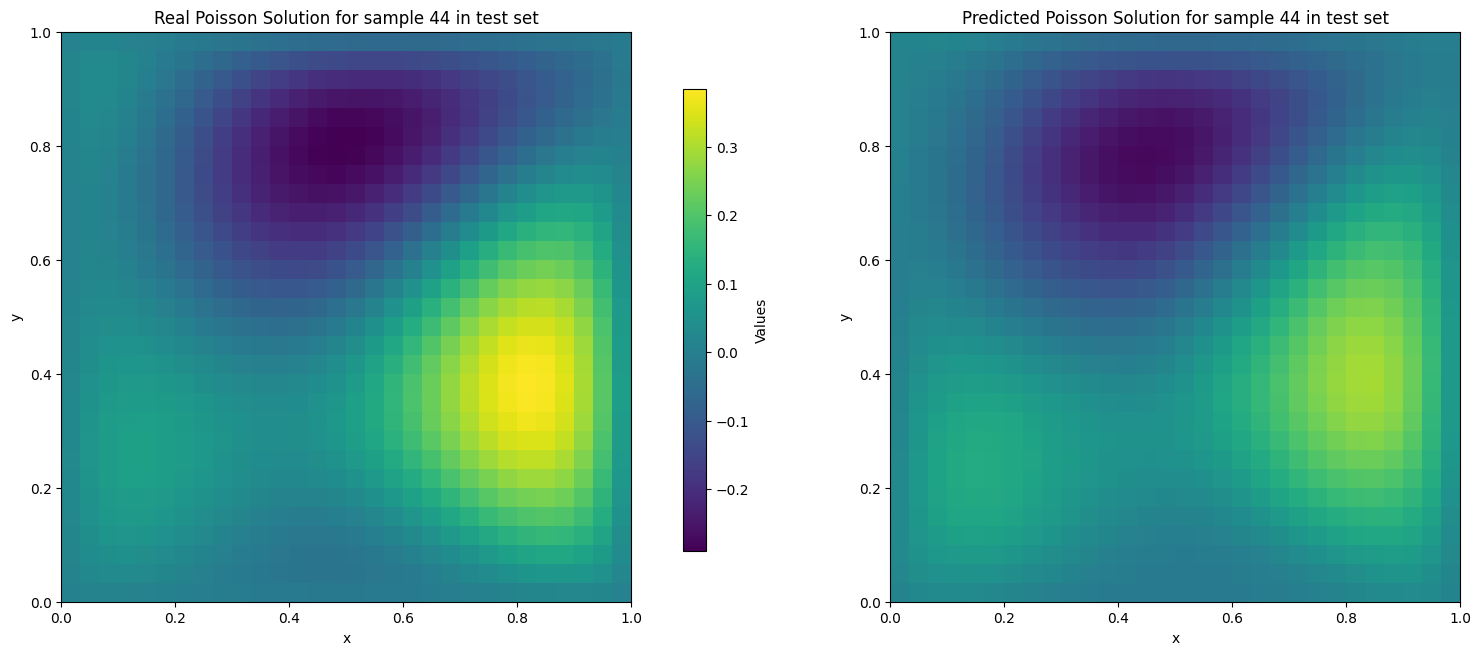

The relative error for sample 93 in test set is 0.1732759028673172


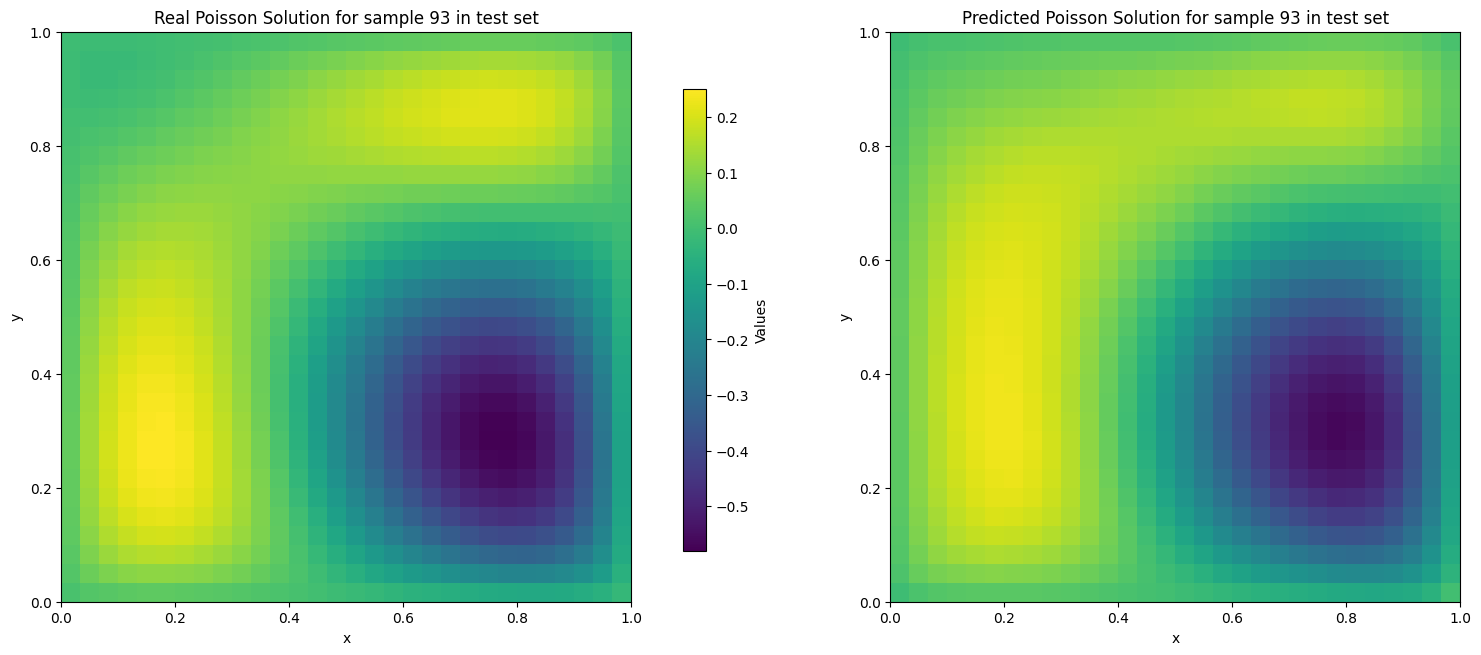

The relative error for sample 75 in test set is 0.15508407354354858


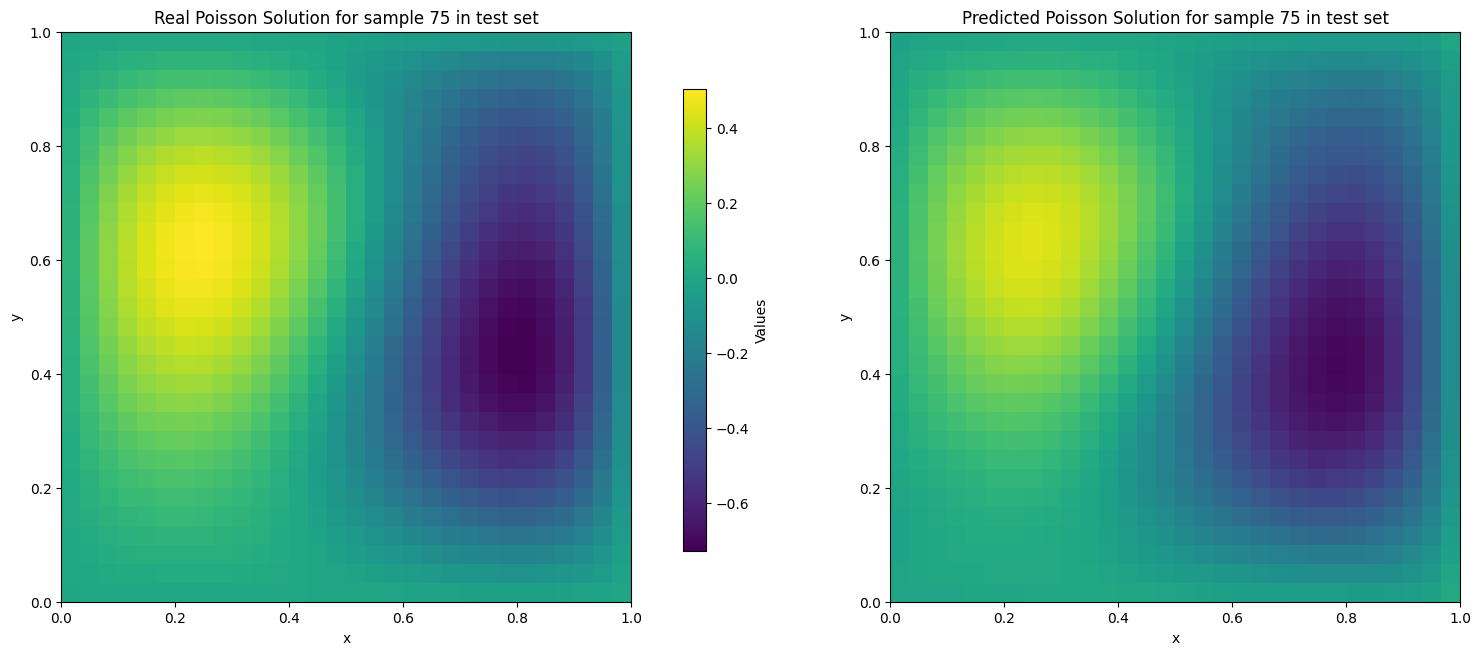

The relative error for sample 9 in test set is 0.12001016736030579


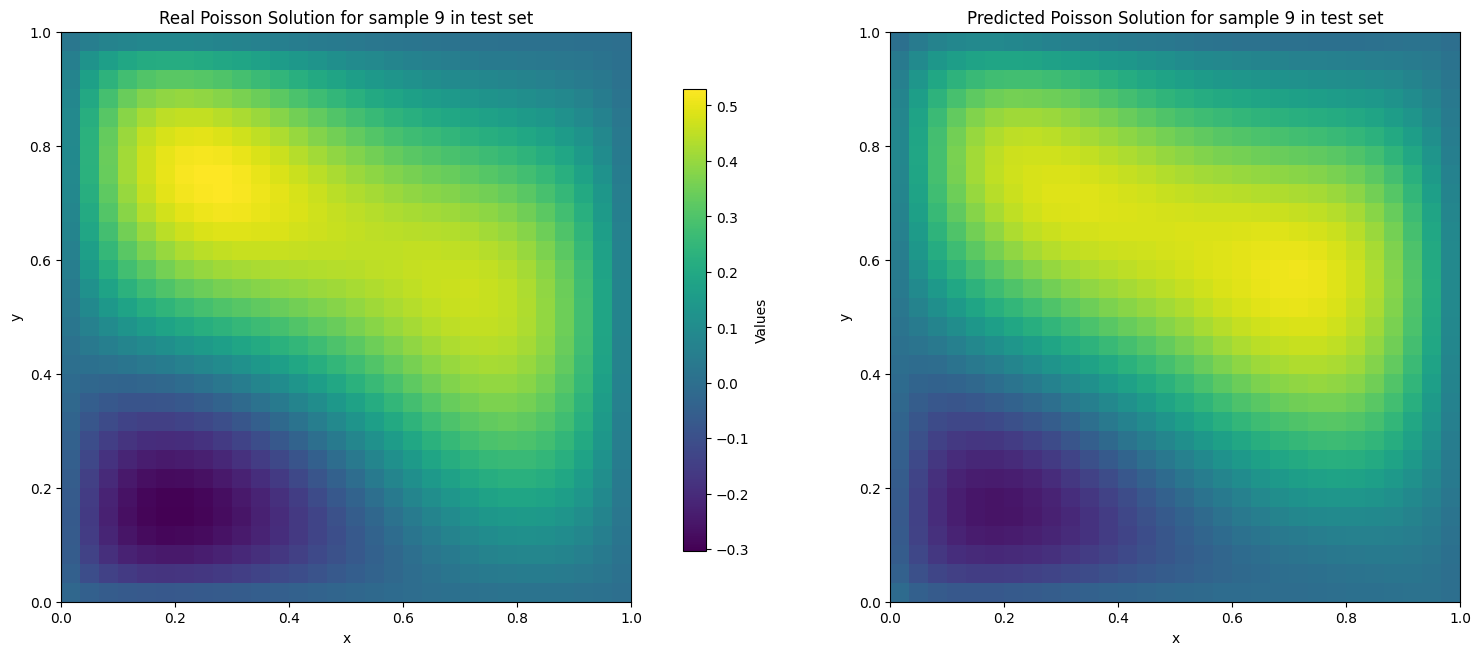

The relative error for sample 16 in test set is 0.11831769347190857


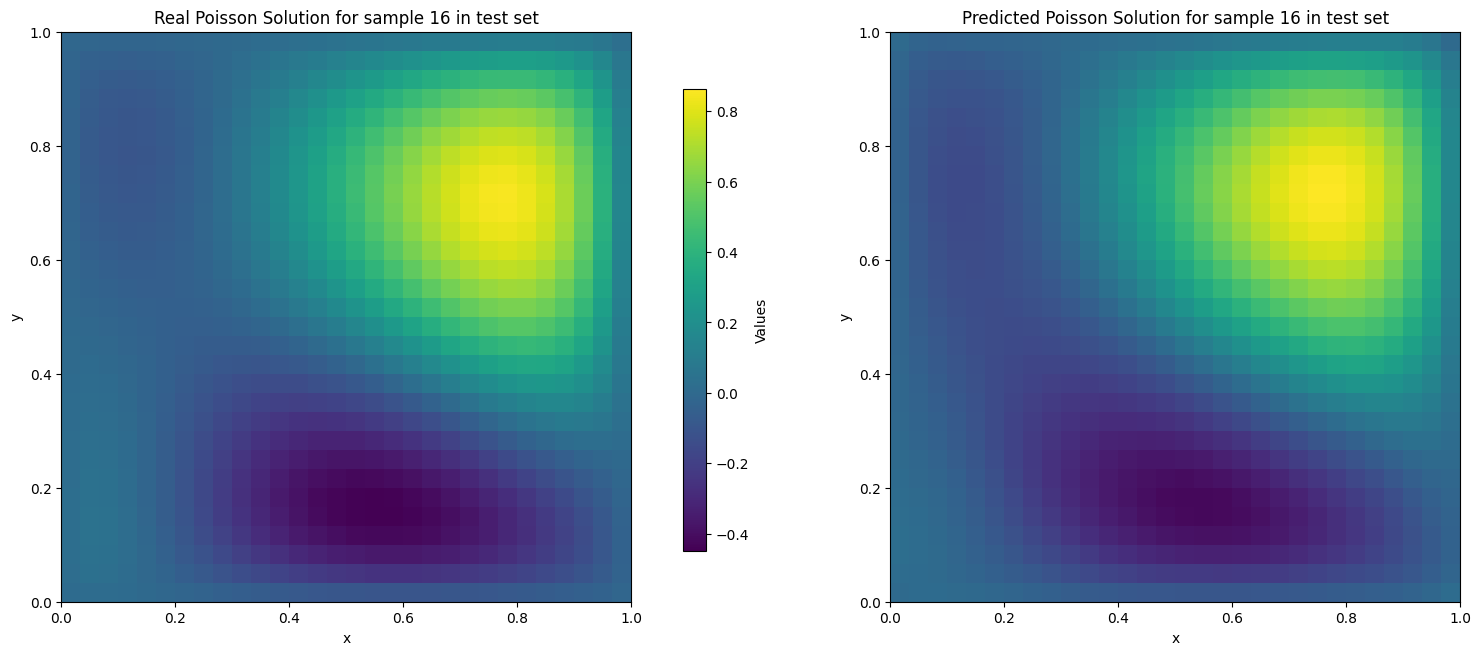

In [27]:
for j in top_k.indices:
    i = j.item()    
    print(f'The relative error for sample {i} in test set is {test_relative_l2_err[j].item()}')
    temp = all_predictions[boundary + i].reshape(n_points, n_points)

    # 创建一个包含两张图片的图形
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # 计算 vmin 和 vmax
    vmin = min(solutions[boundary + i].min(), temp.min())
    vmax = max(solutions[boundary + i].max(), temp.max())
        
    # 第一个图片：Real Solution
    im1 = axs[0].imshow(solutions[boundary + i], extent=(0, 1, 0, 1), origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0].set_title(f'Real Poisson Solution for sample {i} in test set')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    
    # 第二个图片：Predicted Solution
    im2 = axs[1].imshow(temp, extent=(0, 1, 0, 1), origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1].set_title(f'Predicted Poisson Solution for sample {i} in test set')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    
    # 添加统一的 color bar
    cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.51, pad=0.04)
    cbar.set_label('Values')
    
    # 显示图形
    plt.tight_layout()
    plt.show()
